In [2]:
# 代码块1：导入必要的库和设置
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
import ast
from wordcloud import WordCloud

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'MicroSoft YaHei', 'STSong', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

In [3]:
# 代码块2：数据加载和预处理
processed_data_with_words_path = 'E:/pythonProject/python_exercise/naza2_analysis/output/processed_data_with_words.csv'

print(f"正在从 {processed_data_with_words_path} 加载数据...")
try:
    df = pd.read_csv(processed_data_with_words_path, encoding='utf-8-sig')
    print("数据加载成功！")
    
    df['words'] = df['words'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    print("'words' 列已从字符串转换为列表。")
    
    df['comment_time'] = pd.to_datetime(df['comment_time'])
    print("'comment_time' 列已转换为 datetime 类型。")
    
except Exception as e:
    print(f"加载或处理数据时发生错误：{e}")
    raise

正在从 E:/pythonProject/python_exercise/naza2_analysis/output/processed_data_with_words.csv 加载数据...
数据加载成功！
'words' 列已从字符串转换为列表。
'comment_time' 列已转换为 datetime 类型。


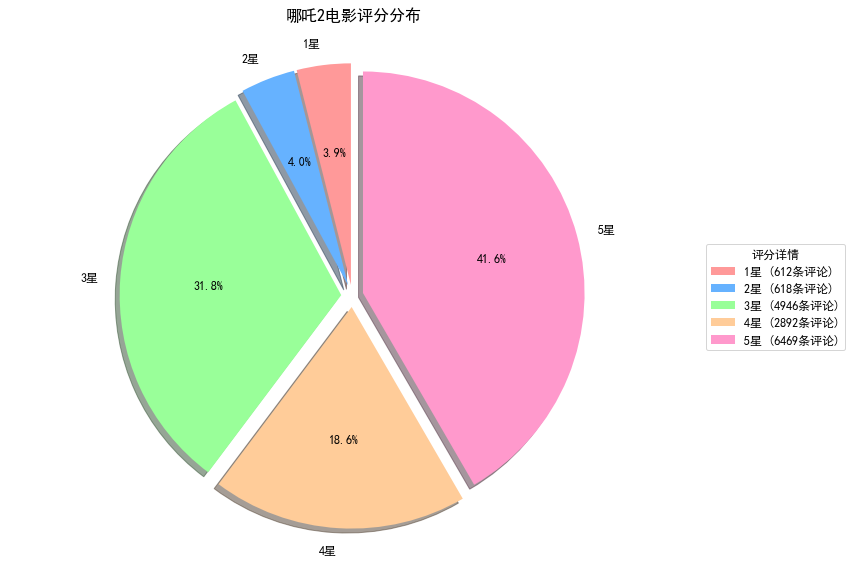

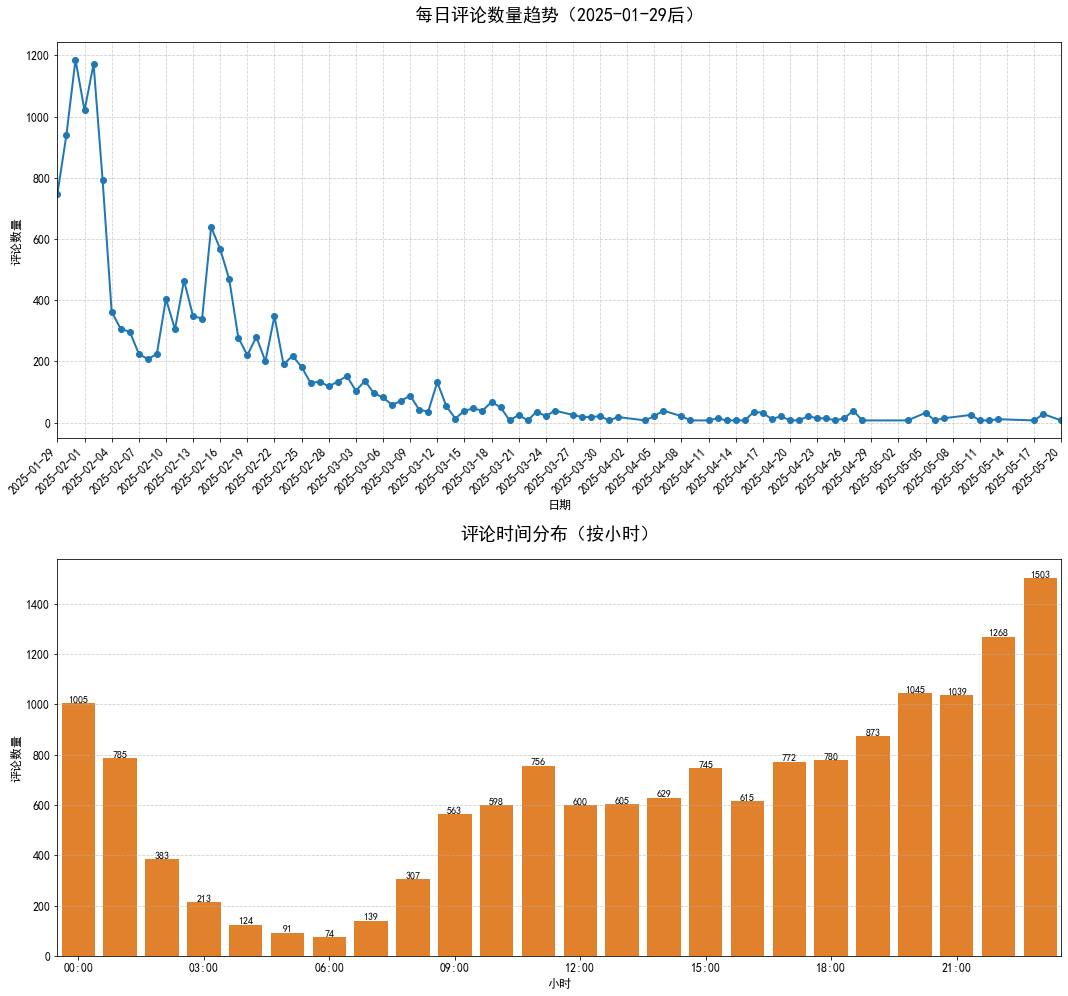

In [4]:
# 代码块3：基础统计分析
# 1. 评分分布分析
def analyze_score_distribution(df):
    plt.figure(figsize=(12, 8))
    
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']
    score_counts = df['score'].value_counts().sort_index()
    
    patches, texts, autotexts = plt.pie(score_counts, 
                                      labels=[f'{i}星' for i in score_counts.index],
                                      colors=colors,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      shadow=True,
                                      explode=[0.05] * len(score_counts),
                                      textprops={'fontsize': 12, 'color': 'black'})
    
    plt.title('哪吒2电影评分分布', fontsize=16, pad=20)
    plt.legend(patches, 
              [f'{i}星 ({count}条评论)' for i, count in zip(score_counts.index, score_counts)],
              title="评分详情",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# 2. 时间分布分析
def analyze_time_distribution(df):
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))
    
    # 只保留2025年1月29日之后的数据
    start_date = pd.to_datetime('2025-01-29')
    df_filtered = df[df['comment_time'] >= start_date]
    
    # 按日期统计评论数量
    daily_counts = df_filtered['comment_time'].dt.date.value_counts().sort_index()
    
    ax1.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
    ax1.set_title('每日评论数量趋势（2025-01-29后）', fontsize=18, pad=20)
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel('评论数量', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # 设置日期刻度
    date_range = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max(), freq='3D')
    ax1.set_xticks(date_range)
    ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in date_range], rotation=45, ha='right')
    ax1.set_xlim(daily_counts.index.min(), daily_counts.index.max())
    
    # 按小时统计评论数量
    hourly_counts = df_filtered['comment_time'].dt.hour.value_counts().sort_index()
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=ax2, color='#ff7f0e')
    ax2.set_title('评论时间分布（按小时）', fontsize=18, pad=20)
    ax2.set_xlabel('小时', fontsize=12)
    ax2.set_ylabel('评论数量', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6, axis='y')
    
    # 设置x轴刻度
    ax2.set_xticks(range(0, 24, 3))
    ax2.set_xticklabels([f'{i:02d}:00' for i in range(0, 24, 3)])
    
    # 添加数值标签
    for bar in ax2.patches:
        ax2.text(bar.get_x() + bar.get_width() / 2., bar.get_height(),
                f'{int(bar.get_height())}',
                ha='center', va='bottom', fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()
    
    return df_filtered

# 运行基础统计分析
analyze_score_distribution(df)
df_filtered = analyze_time_distribution(df)

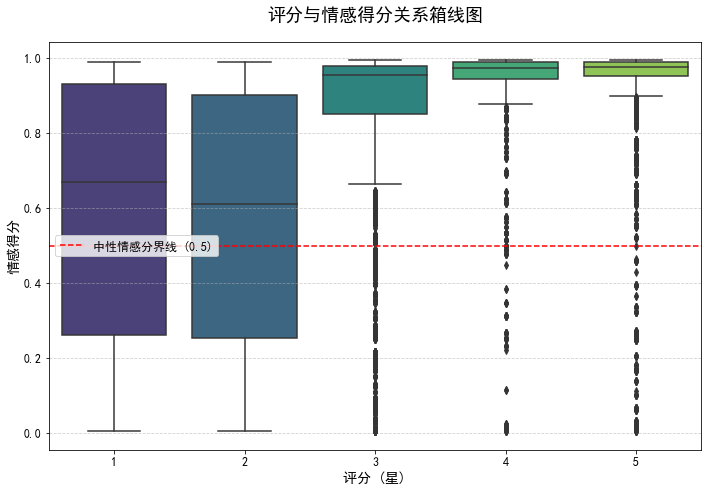

In [5]:
# 代码块4：情感分析
def analyze_sentiment(df):
    # 定义情感类别
    def get_sentiment_category(score):
        if score > 0.6:
            return '正面'
        elif 0.4 <= score <= 0.6:
            return '中性'
        else:
            return '负面'
    
    df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)
    
    # 绘制评分与情感得分的箱线图
    plt.figure(figsize=(10, 7))
    df['score'] = df['score'].astype('category')
    score_order = sorted(df['score'].unique())
    df['score'] = df['score'].cat.reorder_categories(score_order, ordered=True)
    
    sns.boxplot(x='score', y='sentiment_score', data=df, palette='viridis')
    plt.title('评分与情感得分关系箱线图', fontsize=18, pad=20)
    plt.xlabel('评分 (星)', fontsize=14)
    plt.ylabel('情感得分', fontsize=14)
    plt.axhline(y=0.5, color='red', linestyle='--', label='中性情感分界线 (0.5)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()
    plt.show()
    
    return df

# 运行情感分析
df = analyze_sentiment(df)

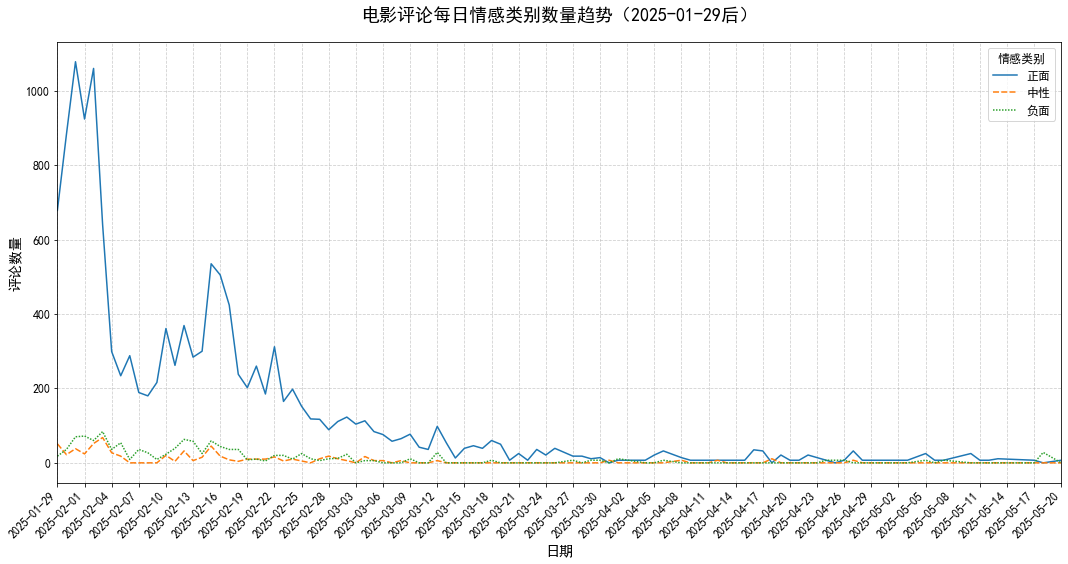


情感类别统计信息：

各情感类别的评论数量：
sentiment_category
正面    13653
中性      644
负面     1215
dtype: int64

各情感类别的平均每日评论数：
sentiment_category
正面    142.218750
中性      6.708333
负面     12.656250
dtype: float64


In [6]:
# 代码块5：情感类别分析
def analyze_sentiment_categories(df):
    # 只保留2025年1月29日之后的数据
    start_date = pd.to_datetime('2025-01-29')
    df_filtered = df[df['comment_time'] >= start_date]

    # 按日期和情感类别分组，计算每日各情感类别的数量
    daily_sentiment_category_counts = df_filtered.groupby([df_filtered['comment_time'].dt.date, 'sentiment_category']).size().unstack(fill_value=0)

    # 按日期排序
    daily_sentiment_category_counts = daily_sentiment_category_counts.sort_index()

    # 绘制每日各情感类别数量的折线图
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=daily_sentiment_category_counts[['正面', '中性', '负面']])

    # 设置标题和标签
    plt.title('电影评论每日情感类别数量趋势（2025-01-29后）', fontsize=18, pad=20)
    plt.xlabel('日期', fontsize=14)
    plt.ylabel('评论数量', fontsize=14)

    # 改进日期刻度显示
    date_range = pd.date_range(start=daily_sentiment_category_counts.index.min(), 
                              end=daily_sentiment_category_counts.index.max(), 
                              freq='3D')
    plt.xticks(date_range, [d.strftime('%Y-%m-%d') for d in date_range], rotation=45, ha='right')

    # 设置x轴范围，确保显示完整
    plt.xlim(daily_sentiment_category_counts.index.min(), daily_sentiment_category_counts.index.max())

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='情感类别')

    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print("\n情感类别统计信息：")
    print("\n各情感类别的评论数量：")
    print(daily_sentiment_category_counts[['正面', '中性', '负面']].sum())
    print("\n各情感类别的平均每日评论数：")
    print(daily_sentiment_category_counts[['正面', '中性', '负面']].mean())

# 运行情感类别分析
analyze_sentiment_categories(df)

In [16]:
# 代码块3-8：数据可视化分析 (使用指定字体文件路径) - 修复 SyntaxError
# 确保 df 中已加载数据，包含 comment_time, score, sentiment_score, useful_count, words 列
# 确保 df 中已创建 sentiment_category 列（如果还没有，可以运行下面的get_sentiment_category代码）
# 确保 df 中已创建 processed_words_list 列（如果还没有，可以运行下面的process_words_list_to_text和生成processed_words_list代码）

import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
import ast
from collections import Counter
import re
import matplotlib.font_manager as fm # 导入字体管理器

# 设置中文字体属性
# !!! 请将这里的字体文件路径修改为您的系统中 simsun.ttc 的实际完整路径 !!!
# 示例路径，请根据您的实际情况修改
font_path = 'C:/Windows/Fonts/simsun.ttc'

# 检查字体文件是否存在
if not os.path.exists(font_path):
    print(f"错误: 未找到指定的字体文件 {font_path}，图表中文字符可能无法正常显示。")
    font_properties = None
else:
    font_properties = fm.FontProperties(fname=font_path)

# 设置负号正常显示
plt.rcParams['axes.unicode_minus'] = False
# 可选：设置全局字号（如果需要）
plt.rcParams['font.size'] = 12


# 定义停用词列表（使用与add_words_column.py相同的停用词） - 已修复 '她们' 的语法错误
# 请将此停用词列表与您在数据预处理时使用的保持一致
stop_words = set([
    # 程度词
    '很', '太', '非常', '十分', '特别', '比较', '更加', '最', '更', '极', '极其', '相当', '稍微', '有点',
    # 时间词
    '已经', '曾经', '总是', '经常', '从来', '一直', '马上', '立刻', '刚刚', '终于',
    # 代词
    '我', '你', '他', '她', '它', '我们', '你们', '他们', '她们', '它们', '自己', '别人', '大家', # <--- 修复在这里
    # 连词
    '和', '与', '及', '而', '或', '但', '然而', '因此', '所以', '因为', '由于', '如果', '那么', '虽然', '可是',
    # 语气词
    '的', '了', '是', '在', '有', '就', '都', '也', '还', '又', '才', '并', '没有', '不是',
    # 数量词
    '一个', '一种', '一些', 有些', '这个', '那个', '那些', '这些', '这', '那', '之', '总', '各', '位', '种', '些',
    # 其他无意义词
    '等等', '一样', '一般', '随便', '任何', '什么', '怎样', '如何', '为什么', '哪里', '何时', '多久', '多少', '什么样', '怎么样',
    '一方面', '另一方面', '与此同时', '况且', '何况', '再说', '而是', '不及', '与其', '为了', '以便', '以免', '不论', '不管',
    '即使', '既然', '自从', '直到', '因为', '由于', '除非', '与其说', '不如说', '之类', '以内', '以外', '以上', '以下',
    '之前', '之后', '之间', '之中', '之外', '以来'
])


# 定义情感类别（如果sentiment_category列还不存在）
def get_sentiment_category(score):
    if score > 0.6:
        return '正面'
    elif 0.4 <= score <= 0.6:
        return '中性'
    else:
        return '负面'
if 'sentiment_category' not in df.columns:
     print("正在生成 'sentiment_category' 列...")
     df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)
     print("'sentiment_category' 列已生成。")


# 定义process_words_list_to_text 函数（与add_words_column.py中的过滤逻辑相同）
def process_words_list_to_text(words_list):
    if not isinstance(words_list, list) or not words_list:
        return []
    processed_words = [word for word in words_list
            if word not in stop_words
            and len(word.strip()) > 1
            and not (isinstance(word, (int, float)) or (isinstance(word, str) and word.isdigit()))
            and not (isinstance(word, str) and re.match(r'^[a-zA-Z]+$', word))
            and not (isinstance(word, str) and re.match(r'^\W+$', word))
    ]
    return processed_words

# 生成 processed_words_list 列（如果还没有）
if 'processed_words_list' not in df.columns:
    print("正在生成 'processed_words_list' 列...")
    # 如果df['words']加载进来是字符串，且未在数据加载时转换，请在此处转换
    # if isinstance(df['words'].iloc[0], str): # 根据实际数据类型判断是否需要转换
    #      df['words'] = df['words'].apply(ast.literal_eval)
    df['processed_words_list'] = df['words'].apply(process_words_list_to_text)
    print("'processed_words_list' 列已生成。")


# 1. 评分分布分析
print("\n进行评分分布分析...")
plt.figure(figsize=(12, 8))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']
score_counts = df['score'].value_counts().sort_index()
patches, texts, autotexts = plt.pie(score_counts,
                                  labels=[f'{i}星' for i in score_counts.index],
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  shadow=True,
                                  explode=[0.05] * len(score_counts),
                                  textprops={'fontsize': 12, 'color': 'black'})
plt.title('哪吒2电影评分分布', fontsize=16, pad=20, fontproperties=font_properties) # 使用指定字体
plt.legend(patches,
          [f'{i}星 ({count}条评论)' for i, count in zip(score_counts.index, score_counts)],
          title="评分详情",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop=font_properties) # 使用指定字体
plt.axis('equal')
plt.tight_layout()
plt.show()


# 2. 时间分布分析
print("\n进行时间分布分析...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))

start_date = pd.to_datetime('2025-01-29')
df_filtered = df[df['comment_time'] >= start_date]

daily_counts = df_filtered['comment_time'].dt.date.value_counts().sort_index()
ax1.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
ax1.set_title('每日评论数量趋势（2025-01-29后）', fontsize=18, pad=20, fontproperties=font_properties) # 使用指定字体
ax1.set_xlabel('日期', fontsize=12, fontproperties=font_properties) # 使用指定字体
ax1.set_ylabel('评论数量', fontsize=12, fontproperties=font_properties) # 使用指定字体
ax1.grid(True, linestyle='--', alpha=0.6)
date_range = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max(), freq='3D')
ax1.set_xticks(date_range)
ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in date_range], rotation=45, ha='right')
ax1.set_xlim(daily_counts.index.min(), daily_counts.index.max())


hourly_counts = df_filtered['comment_time'].dt.hour.value_counts().sort_index()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=ax2, color='#ff7f0e')
ax2.set_title('评论时间分布（按小时）', fontsize=18, pad=20, fontproperties=font_properties) # 使用指定字体
ax2.set_xlabel('小时', fontsize=12, fontproperties=font_properties) # 使用指定字体
ax2.set_ylabel('评论数量', fontsize=12, fontproperties=font_properties) # 使用指定字体
ax2.grid(True, linestyle='--', alpha=0.6, axis='y')
ax2.set_xticks(range(0, 24, 3))
ax2.set_xticklabels([f'{i:02d}:00' for i in range(0, 24, 3)])
for bar in ax2.patches:
    ax2.text(bar.get_x() + bar.get_width() / 2., bar.get_height(),
            f'{int(bar.get_height())}',
            ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()


# 3. 情感分析
print("\n进行情感分析可视化...")
# df['sentiment_category'] 已在前面生成
plt.figure(figsize=(10, 7))
df['score'] = df['score'].astype('category')
score_order = sorted(df['score'].unique())
df['score'] = df['score'].cat.reorder_categories(score_order, ordered=True)
sns.boxplot(x='score', y='sentiment_score', data=df, palette='viridis')
plt.title('评分与情感得分关系箱线图', fontsize=18, pad=20, fontproperties=font_properties) # 使用指定字体
plt.xlabel('评分 (星)', fontsize=14, fontproperties=font_properties) # 使用指定字体
plt.ylabel('情感得分', fontsize=14, fontproperties=font_properties) # 使用指定字体
plt.axhline(y=0.5, color='red', linestyle='--', label='中性情感分界线 (0.5)')
plt.legend(prop=font_properties) # 使用指定字体
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.tight_layout()
plt.show()


# 4. 情感类别分析
print("\n进行情感类别趋势分析...")
start_date = pd.to_datetime('2025-01-29')
df_filtered = df[df['comment_time'] >= start_date]
daily_sentiment_category_counts = df_filtered.groupby([df_filtered['comment_time'].dt.date, 'sentiment_category']).size().unstack(fill_value=0)
daily_sentiment_category_counts = daily_sentiment_category_counts.sort_index()

plt.figure(figsize=(15, 8))
sns.lineplot(data=daily_sentiment_category_counts[['正面', '中性', '负面']])
plt.title('电影评论每日情感类别数量趋势（2025-01-29后）', fontsize=18, pad=20, fontproperties=font_properties) # 使用指定字体
plt.xlabel('日期', fontsize=14, fontproperties=font_properties) # 使用指定字体
plt.ylabel('评论数量', fontsize=14, fontproperties=font_properties) # 使用指定字体
date_range = pd.date_range(start=daily_sentiment_category_counts.index.min(),
                          end=daily_sentiment_category_counts.index.max(),
                          freq='3D')
plt.xticks(date_range, [d.strftime('%Y-%m-%d') for d in date_range], rotation=45, ha='right')
plt.xlim(daily_sentiment_category_counts.index.min(), daily_sentiment_category_counts.index.max())
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='情感类别', prop=font_properties) # 使用指定字体
plt.tight_layout()
plt.show()

# 打印统计信息
print("\n情感类别统计信息：")
print("\n各情感类别的评论数量：")
print(daily_sentiment_category_counts[['正面', '中性', '负面']].sum())
print("\n各情感类别的平均每日评论数：")
print(daily_sentiment_category_counts[['正面', '中性', '负面']].mean())


# 5. 关键词分析并生成条形图
print("\n进行关键词分析...")
def plot_word_frequency(words, title, top_n=20):
    word_counts = Counter(words)
    top_words = word_counts.most_common(top_n)
    if not top_words:
        print(f"警告：{title} 没有找到足够的高频词进行可视化。")
        return
    plt.figure(figsize=(12, 6))
    words, counts = zip(*top_words)
    y_pos = range(len(words))
    plt.barh(y_pos, counts, align='center', color='skyblue')
    plt.yticks(y_pos, words, fontproperties=font_properties) # 使用指定字体
    plt.xlabel('出现次数', fontsize=12, fontproperties=font_properties) # 使用指定字体
    plt.title(f'{title} - 高频词统计 (Top {top_n})', fontsize=15, pad=20, fontproperties=font_properties) # 使用指定字体
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(v), va='center', fontsize=10)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(f"\n{title} - 词频统计 (Top {top_n}):")
    for word, count in top_words:
        print(f"{word}: {count}")

# 按情感类别分析
print("\n正在分析情感类别关键词...")
for sentiment in ['正面', '中性', '负面']:
    group = df[df['sentiment_category'] == sentiment]
    if not group.empty:
        all_words = []
        for words_list in group['processed_words_list']:
            all_words.extend(words_list)
        plot_word_frequency(all_words, f'{sentiment}评论关键词')
    else:
        print(f"警告：没有找到{sentiment}评论")

# 按评分分析
print("\n正在分析评分关键词...")
for score in sorted(df['score'].unique()):
    group = df[df['score'] == score]
    if not group.empty:
        all_words = []
        for words_list in group['processed_words_list']:
            all_words.extend(words_list)
        plot_word_frequency(all_words, f'{score}星评论关键词')
    else:
        print(f"警告：没有找到{score}星评论")

# 分析高互动评论
print("\n正在分析高互动评论关键词...")
median_useful = df['useful_count'].median()
high_interaction = df[df['useful_count'] > median_useful]
if not high_interaction.empty:
    all_words = []
    for words_list in high_interaction['processed_words_list']:
        all_words.extend(words_list)
    plot_word_frequency(all_words, '高互动评论关键词')
else:
    print("警告：没有找到高互动评论")

# 6. 输出各评分的平均情感得分
print("\n各评分的平均情感得分：")
print(df.groupby('score')['sentiment_score'].mean().sort_index())

SyntaxError: invalid syntax (<ipython-input-16-33dc32b18eef>, line 48)